# REINFORCE Training for Dermatology Triage Clinic

**Reinforcement Learning Summative Assignment**

This notebook trains a REINFORCE (Vanilla Policy Gradient) - Custom PyTorch Implementation agent on the custom dermatology clinic triage environment.

## Workflow:
1. **Setup**: Mount Drive, install dependencies
2. **Environment**: Embed ClinicEnv code
3. **Configurations**: Load 10 REINFORCE hyperparameter configs
4. **Quick Sweep**: Train all 10 configs for 50K steps each
5. **Analysis**: Identify best performing configuration
6. **Full Training**: Train best config with 5 seeds for 200K steps
7. **Evaluation**: Generate plots and performance metrics
8. **Export**: Save models and results to Google Drive

**Estimated Runtime**: 6-8 hours on Colab GPU


## 1. Setup: Mount Google Drive & Install Dependencies


In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set up project directory on Drive
import os
PROJECT_DIR = '/content/drive/MyDrive/RL_Summative'
os.makedirs(PROJECT_DIR, exist_ok=True)
os.makedirs(f'{PROJECT_DIR}/models/reinforce', exist_ok=True)
os.makedirs(f'{PROJECT_DIR}/logs/reinforce', exist_ok=True)
os.makedirs(f'{PROJECT_DIR}/results', exist_ok=True)
os.makedirs(f'{PROJECT_DIR}/plots', exist_ok=True)

print(f"✓ Google Drive mounted")
print(f"✓ Project directory: {PROJECT_DIR}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Google Drive mounted
✓ Project directory: /content/drive/MyDrive/RL_Summative


In [2]:
# Install required packages
# NOTE: numpy 1.26.4 is specified to avoid binary incompatibility with torch
# Install numpy FIRST, then restart runtime before importing any libraries
%pip install -q numpy==1.26.4
%pip install -q torch
%pip install -q gymnasium
%pip install -q stable-baselines3
%pip install -q sb3-contrib
%pip install -q matplotlib
%pip install -q seaborn
%pip install -q pandas
%pip install -q tqdm
%pip install -q imageio

print("\n" + "="*60)
print("✓ All packages installed successfully!")
print("="*60)
print("\n⚠️  IMPORTANT: RESTART RUNTIME NOW")
print("Click 'Runtime' → 'Restart runtime' in the menu above")
print("Then run ALL cells again from the beginning")
print("="*60)


✓ All packages installed successfully!

⚠️  IMPORTANT: RESTART RUNTIME NOW
Click 'Runtime' → 'Restart runtime' in the menu above
Then run ALL cells again from the beginning


In [3]:
# Import libraries
import gymnasium as gym
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time
from typing import Tuple, Dict, Any, Optional, List
from tqdm.notebook import tqdm
from gymnasium import spaces
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported successfully!")


✓ Libraries imported successfully!


## 2. Embed ClinicEnv (Custom Gymnasium Environment)


In [4]:
class ClinicEnv(gym.Env):
    """
    Dermatology Clinic Triage Environment - Optimized for REINFORCE Stability
    """
    metadata = {"render_modes": ["human", "rgb_array", "ansi"], "render_fps": 6}

    def __init__(self, seed: Optional[int] = None, max_steps: int = 500, render_mode: Optional[str] = None):
        super().__init__()
        self.max_steps = max_steps
        self.render_mode = render_mode

        # Spaces
        obs_low = np.array([0.0] * 15, dtype=np.float32)
        obs_high = np.array([1.0] * 15, dtype=np.float32)
        self.observation_space = spaces.Box(obs_low, obs_high, dtype=np.float32)
        self.action_space = spaces.Discrete(8)

        # State
        self.step_count = 0
        self.num_open_rooms = 1
        self.queue = []
        self.current_patient = None
        self.total_wait = 0.0
        self.episode_stats = {"correct_triages": 0, "incorrect_triages": 0, "total_patients": 0, "total_wait_time": 0.0, "total_reward": 0.0}

        if seed is not None: self.seed(seed)
        self.reset()

    def seed(self, seed: Optional[int] = None):
        self._seed = seed
        random.seed(seed)
        np.random.seed(seed)
        return [seed]

    def _sample_patient(self) -> Dict[str, Any]:
        severity = np.random.choice([0, 1, 2, 3], p=[0.4, 0.35, 0.2, 0.05])
        # Reduced noise to 0.02 (Crucial for learnability)
        symptom_embed = np.clip(np.random.normal(loc=0.2 + 0.25 * severity, scale=0.02, size=(8,)), 0.0, 1.0)
        return {
            "severity": int(severity),
            "age_norm": float(np.clip(np.random.normal(0.5, 0.15), 0.0, 1.0)),
            "duration_norm": float(np.clip(np.random.exponential(0.5), 0.0, 1.0)),
            "fever_flag": float(1.0 if np.random.rand() < (0.05 + 0.2 * severity) else 0.0),
            "infection_flag": float(1.0 if np.random.rand() < (0.05 + 0.25 * severity) else 0.0),
            "symptom_embed": symptom_embed,
            "wait_time": 0.0
        }

    def _form_observation(self, patient: Dict[str, Any]) -> np.ndarray:
        vec = [patient["age_norm"], patient["duration_norm"], patient["fever_flag"], patient["infection_flag"]]
        vec += list(patient["symptom_embed"])
        vec += [1.0 if self.num_open_rooms > 0 else 0.0, np.clip(len(self.queue) / 10.0, 0.0, 1.0), np.clip(self.step_count / self.max_steps, 0.0, 1.0)]
        return np.array(vec, dtype=np.float32)

    def reset(self, seed: Optional[int] = None, options: Optional[Dict] = None) -> Tuple[np.ndarray, Dict[str, Any]]:
        super().reset(seed=seed)
        if seed is not None: self.seed(seed)
        self.step_count = 0
        self.num_open_rooms = 1
        self.queue = [self._sample_patient() for _ in range(3)]
        self.current_patient = None
        self.total_wait = 0.0
        self.episode_stats = {"correct_triages": 0, "incorrect_triages": 0, "total_patients": 0, "total_wait_time": 0.0, "total_reward": 0.0}
        self._maybe_spawn_next()
        return self._form_observation(self.current_patient), self._get_info()

    def _maybe_spawn_next(self):
        if self.current_patient is None:
            self.current_patient = self.queue.pop(0) if len(self.queue) > 0 else self._sample_patient()

    def _get_correct_action(self, severity: int) -> int:
        return {0: 2, 1: 1, 2: 0, 3: 3}.get(severity, 2)

    def _get_info(self) -> Dict[str, Any]:
        if self.current_patient is None: return {"queue_length": len(self.queue)}
        return {"correct_action": int(self._get_correct_action(self.current_patient["severity"])), "episode_stats": self.episode_stats.copy()}

    def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, Dict[str, Any]]:
        self.step_count += 1
        reward = 0.0
        correct_action = self._get_correct_action(self.current_patient["severity"])

        # Increased Rewards to stabilize gradients
        if action == correct_action:
            reward += {0: 5.0, 1: 5.0, 2: 10.0, 3: 15.0}.get(self.current_patient["severity"], 5.0)
            self.episode_stats["correct_triages"] += 1
        else:
            reward -= 1.0
            self.episode_stats["incorrect_triages"] += 1

        if action == 6: self.num_open_rooms += 1
        elif action == 7 and self.num_open_rooms > 0: self.num_open_rooms -= 1
        elif action == 4:
            self.current_patient["wait_time"] += 1.0
            self.queue.append(self.current_patient)
            self.current_patient = None
        else:
            self.current_patient = None

        wait_increment = 0.01 * len(self.queue)
        for p in self.queue: p["wait_time"] += 1.0
        reward -= (0.01 * wait_increment + 0.05 * self.num_open_rooms)
        self.episode_stats["total_reward"] += reward

        self._maybe_spawn_next()
        return self._form_observation(self.current_patient), float(reward), False, self.step_count >= self.max_steps, self._get_info()

print("✓ ClinicEnv (REINFORCE Optimized) defined successfully!")

✓ ClinicEnv (REINFORCE Optimized) defined successfully!


## 3. Load REINFORCE Configurations (10 Hyperparameter Sets)


In [5]:
# Embedded REINFORCE configurations (Optimized for Stability)
REINFORCE_CONFIGS = {
  "configs": [
    {
      "id": "reinforce_baseline_stabilized",
      "description": "Standard configuration with Baseline enabled",
      "learning_rate": 0.0003,    # Conservative start
      "gamma": 0.99,
      "hidden_dims": [256, 256],  # Larger Net
      "use_baseline": True,       # CRITICAL: Reduces variance
      "max_grad_norm": 0.5,
      "entropy_coef": 0.01
    },
    {
      "id": "reinforce_high_entropy",
      "description": "High entropy to force exploration",
      "learning_rate": 0.0003,
      "gamma": 0.99,
      "hidden_dims": [256, 256],
      "use_baseline": True,
      "max_grad_norm": 0.5,
      "entropy_coef": 0.05        # Increased entropy
    },
    {
      "id": "reinforce_slow_learner",
      "description": "Very low LR for maximum stability",
      "learning_rate": 0.0001,    # Slower but safer
      "gamma": 0.99,
      "hidden_dims": [256, 256],
      "use_baseline": True,
      "max_grad_norm": 0.5,
      "entropy_coef": 0.01
    },
    {
      "id": "reinforce_fast_learner",
      "description": "Higher LR (Risky)",
      "learning_rate": 0.001,
      "gamma": 0.99,
      "hidden_dims": [256, 256],
      "use_baseline": True,
      "max_grad_norm": 1.0,
      "entropy_coef": 0.01
    },
    {
      "id": "reinforce_no_baseline",
      "description": "Ablation study: No baseline (likely unstable)",
      "learning_rate": 0.0001,
      "gamma": 0.99,
      "hidden_dims": [256, 256],
      "use_baseline": False,      # Disabled for comparison
      "max_grad_norm": 0.5,
      "entropy_coef": 0.01
    },
    {
      "id": "reinforce_long_horizon",
      "description": "High gamma for long-term consequences",
      "learning_rate": 0.0003,
      "gamma": 0.995,
      "hidden_dims": [256, 256],
      "use_baseline": True,
      "max_grad_norm": 0.5,
      "entropy_coef": 0.01
    },
    {
      "id": "reinforce_short_horizon",
      "description": "Lower gamma to focus on immediate triage",
      "learning_rate": 0.0003,
      "gamma": 0.95,
      "hidden_dims": [256, 256],
      "use_baseline": True,
      "max_grad_norm": 0.5,
      "entropy_coef": 0.01
    },
    {
      "id": "reinforce_deep_net",
      "description": "Deeper network for complex features",
      "learning_rate": 0.0003,
      "gamma": 0.99,
      "hidden_dims": [256, 256, 256], # 3 Layers
      "use_baseline": True,
      "max_grad_norm": 0.5,
      "entropy_coef": 0.01
    },
    {
      "id": "reinforce_high_reg",
      "description": "High gradient clipping",
      "learning_rate": 0.0005,
      "gamma": 0.99,
      "hidden_dims": [256, 256],
      "use_baseline": True,
      "max_grad_norm": 0.1,       # Strict clipping
      "entropy_coef": 0.01
    },
    {
      "id": "reinforce_balanced",
      "description": "Balanced exploration/exploitation",
      "learning_rate": 0.0005,
      "gamma": 0.99,
      "hidden_dims": [256, 256],
      "use_baseline": True,
      "max_grad_norm": 0.5,
      "entropy_coef": 0.025
    }
  ]
}

configs = REINFORCE_CONFIGS["configs"]
print(f"✓ Loaded {len(configs)} REINFORCE configurations")
for cfg in configs:
    print(f"  - {cfg['id']}: {cfg['description']}")

✓ Loaded 10 REINFORCE configurations
  - reinforce_baseline_stabilized: Standard configuration with Baseline enabled
  - reinforce_high_entropy: High entropy to force exploration
  - reinforce_slow_learner: Very low LR for maximum stability
  - reinforce_fast_learner: Higher LR (Risky)
  - reinforce_no_baseline: Ablation study: No baseline (likely unstable)
  - reinforce_long_horizon: High gamma for long-term consequences
  - reinforce_short_horizon: Lower gamma to focus on immediate triage
  - reinforce_deep_net: Deeper network for complex features
  - reinforce_high_reg: High gradient clipping
  - reinforce_balanced: Balanced exploration/exploitation


In [6]:
# Custom REINFORCE Implementation with Baseline & Normalization

class PolicyNetwork(nn.Module):
    def __init__(self, obs_dim, action_dim, hidden_dims=[256, 256]):
        super().__init__()
        layers = []
        prev_dim = obs_dim
        for hd in hidden_dims:
            layers.extend([nn.Linear(prev_dim, hd), nn.ReLU()])
            prev_dim = hd
        layers.append(nn.Linear(prev_dim, action_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, obs):
        return self.network(obs)

    def get_action(self, obs, deterministic=False):
        obs_tensor = torch.FloatTensor(obs).unsqueeze(0)
        logits = self.forward(obs_tensor)
        probs = torch.nn.functional.softmax(logits, dim=-1)

        if deterministic:
            action = torch.argmax(probs, dim=-1).item()
            log_prob = torch.log(probs[0, action] + 1e-9)
        else:
            dist = torch.distributions.Categorical(probs)
            action = dist.sample().item()
            log_prob = dist.log_prob(torch.tensor(action))

        return action, log_prob

class ValueNetwork(nn.Module):
    def __init__(self, obs_dim, hidden_dims=[256, 256]):
        super().__init__()
        layers = []
        prev_dim = obs_dim
        for hd in hidden_dims:
            layers.extend([nn.Linear(prev_dim, hd), nn.ReLU()])
            prev_dim = hd
        layers.append(nn.Linear(prev_dim, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, obs):
        return self.network(obs).squeeze(-1)

class REINFORCE:
    def __init__(self, env, learning_rate=0.0003, gamma=0.99, hidden_dims=[256, 256],
                 use_baseline=True, max_grad_norm=0.5, entropy_coef=0.01):
        self.env = env
        self.gamma = gamma
        self.entropy_coef = entropy_coef
        self.max_grad_norm = max_grad_norm
        self.use_baseline = use_baseline

        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n

        self.policy = PolicyNetwork(obs_dim, action_dim, hidden_dims)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=learning_rate)

        if use_baseline:
            self.value_net = ValueNetwork(obs_dim, hidden_dims)
            self.value_opt = torch.optim.Adam(self.value_net.parameters(), lr=learning_rate)
        else:
            self.value_net = None

    def compute_returns(self, rewards):
        """Compute normalized returns to reduce variance."""
        R = 0
        returns = []
        for r in reversed(rewards):
            R = r + self.gamma * R
            returns.insert(0, R)

        returns = torch.tensor(returns)
        # Normalize returns (Critical for stability)
        if len(returns) > 1:
            returns = (returns - returns.mean()) / (returns.std() + 1e-9)
        return returns

    def train_episode(self):
        obs, _ = self.env.reset()
        log_probs = []
        rewards = []
        observations = []
        done = False

        while not done:
            observations.append(obs)
            action, log_prob = self.policy.get_action(obs)
            next_obs, reward, term, trunc, _ = self.env.step(action)
            done = term or trunc

            log_probs.append(log_prob)
            rewards.append(reward)
            obs = next_obs

        # Update
        returns = self.compute_returns(rewards)
        log_probs = torch.stack(log_probs)
        obs_tensor = torch.FloatTensor(np.array(observations))

        if self.use_baseline:
            values = self.value_net(obs_tensor)
            advantages = returns - values.detach()

            # Value update
            value_loss = torch.nn.functional.mse_loss(values, returns)
            self.value_opt.zero_grad()
            value_loss.backward()
            self.value_opt.step()
        else:
            advantages = returns

        # Policy Loss
        policy_loss = -(log_probs * advantages).mean()

        self.optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
        self.optimizer.step()

        return sum(rewards), len(rewards)

    def predict(self, obs, deterministic=True):
        action, _ = self.policy.get_action(obs, deterministic)
        return action, None

    def save(self, path):
        state = {'policy': self.policy.state_dict()}
        if self.value_net: state['value'] = self.value_net.state_dict()
        torch.save(state, path)

def evaluate_agent(model, env, num_episodes=20):
    episode_rewards = []
    episode_lengths = []
    triage_accuracies = []

    for _ in range(num_episodes):
        obs, _ = env.reset()
        done = False
        episode_reward = 0.0
        episode_length = 0
        correct = 0
        total = 0

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            episode_reward += reward
            episode_length += 1

            if 'correct_action' in info:
                total += 1
                if action == info['correct_action']:
                    correct += 1

        episode_rewards.append(episode_reward)
        episode_lengths.append(episode_length)
        if total > 0:
            triage_accuracies.append(100.0 * correct / total)

    # Calculate stats
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)
    mean_length = np.mean(episode_lengths)

    if triage_accuracies:
        mean_acc = np.mean(triage_accuracies)
        std_acc = np.std(triage_accuracies)
    else:
        mean_acc = 0.0
        std_acc = 0.0

    # Return dictionary with ALL required keys
    return {
        "mean_reward": mean_reward,
        "std_reward": std_reward,
        "mean_length": mean_length,
        "mean_triage_accuracy": mean_acc,
        "std_triage_accuracy": std_acc
    }

def train_reinforce_config(config, env, num_episodes=100, seed=42):
    env.reset(seed=seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    agent = REINFORCE(env,
                      learning_rate=config["learning_rate"],
                      gamma=config["gamma"],
                      hidden_dims=config.get("hidden_dims", [256, 256]),
                      use_baseline=config.get("use_baseline", True),
                      entropy_coef=config.get("entropy_coef", 0.01))

    for _ in range(num_episodes):
        agent.train_episode()

    return agent, evaluate_agent(agent, env, num_episodes=20)

def save_results_to_csv(results, filename):
    import os
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    pd.DataFrame(results).to_csv(filename, index=False)
    print(f"✓ Results saved to {filename}")

def plot_config_comparison(sweep_df, save_path):
    import matplotlib.pyplot as plt
    import os
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Mean Reward
    axes[0].barh(sweep_df['config_id'], sweep_df['mean_reward'], color='steelblue')
    axes[0].set_xlabel('Mean Reward')
    axes[0].set_title('Reward Comparison')

    # Accuracy
    axes[1].barh(sweep_df['config_id'], sweep_df['triage_accuracy'], color='coral')
    axes[1].set_xlabel('Accuracy (%)')
    axes[1].set_title('Accuracy Comparison')

    plt.tight_layout()
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path)
    print(f"✓ Plot saved to {save_path}")
    plt.show()

print("✓ REINFORCE implementation updated with Normalization & Stability fixes!")

✓ REINFORCE implementation updated with Normalization & Stability fixes!


## 5. Quick Sweep: Train All 10 Configs (50K steps each)

**Purpose**: Identify the best-performing configuration before committing to full training.

**Runtime**: ~2-3 hours on Colab GPU


In [7]:
# Quick sweep training
print("="*60)
print("QUICK SWEEP: Training all 10 configurations")
print("="*60)

sweep_results = []
sweep_models = {}

for i, config in enumerate(configs):
    print(f"\n[{i+1}/10] Training: {config['id']}")
    print(f"Description: {config['description']}")
    print("-" * 60)

    # Create environment
    env = ClinicEnv(seed=42, max_steps=500)

    start_time = time.time()

    # Train
    try:
        model, eval_results = train_reinforce_config(
            config, env,
            num_episodes=500,
            seed=42
        )

        elapsed = time.time() - start_time

        # Store results
        result = {
            "config_id": config["id"],
            "mean_reward": eval_results["mean_reward"],
            "std_reward": eval_results["std_reward"],
            "triage_accuracy": eval_results["mean_triage_accuracy"],
            "mean_length": eval_results["mean_length"],
            "learning_rate": config["learning_rate"],
            "gamma": config["gamma"],
            "use_baseline": config["use_baseline"],
            "entropy_coef": config["entropy_coef"],
            "training_time_sec": elapsed
        }

        sweep_results.append(result)
        sweep_models[config["id"]] = model

        print(f"✓ Completed in {elapsed:.1f}s")
        print(f"  Mean Reward: {eval_results['mean_reward']:.2f} ± {eval_results['std_reward']:.2f}")
        print(f"  Triage Accuracy: {eval_results['mean_triage_accuracy']:.1f}%")

        # Save model to Drive
        model_path = f"{PROJECT_DIR}/models/reinforce/{config['id']}_sweep.pt"
        os.makedirs(os.path.dirname(model_path), exist_ok=True)
        model.save(model_path)
        print(f"  Model saved: {model_path}")

    except Exception as e:
        print(f"✗ Error training {config['id']}: {str(e)}")
        continue

    env.close()

print("\n" + "="*60)
print("SWEEP COMPLETE!")
print("="*60)

QUICK SWEEP: Training all 10 configurations

[1/10] Training: reinforce_baseline_stabilized
Description: Standard configuration with Baseline enabled
------------------------------------------------------------
✓ Completed in 275.0s
  Mean Reward: 133.80 ± 47.53
  Triage Accuracy: 36.8%
  Model saved: /content/drive/MyDrive/RL_Summative/models/reinforce/reinforce_baseline_stabilized_sweep.pt

[2/10] Training: reinforce_high_entropy
Description: High entropy to force exploration
------------------------------------------------------------
✓ Completed in 262.2s
  Mean Reward: 133.80 ± 47.53
  Triage Accuracy: 36.8%
  Model saved: /content/drive/MyDrive/RL_Summative/models/reinforce/reinforce_high_entropy_sweep.pt

[3/10] Training: reinforce_slow_learner
Description: Very low LR for maximum stability
------------------------------------------------------------
✓ Completed in 262.3s
  Mean Reward: -6787.60 ± 0.00
  Triage Accuracy: 0.0%
  Model saved: /content/drive/MyDrive/RL_Summative/mo

## 6. Analyze Results & Select Best Configuration


✓ Results saved to /content/drive/MyDrive/RL_Summative/results/reinforce_sweep_results.csv

SWEEP RESULTS (sorted by mean reward)
                    config_id  mean_reward  triage_accuracy  training_time_sec
        reinforce_no_baseline   697.199700            40.74         286.347654
       reinforce_fast_learner   669.599700            39.83         279.256710
           reinforce_deep_net   548.399700            35.76         309.635548
reinforce_baseline_stabilized   133.799700            36.83         275.037030
       reinforce_high_entropy   133.799700            36.83         262.160502
       reinforce_long_horizon  -146.600300             4.73         274.881349
      reinforce_short_horizon  -524.291255             0.00         270.606618
       reinforce_slow_learner -6787.600000             0.00         262.287723
           reinforce_high_reg -6787.600000             0.00         268.209805
           reinforce_balanced -6787.600000             0.00         266.784530
✓

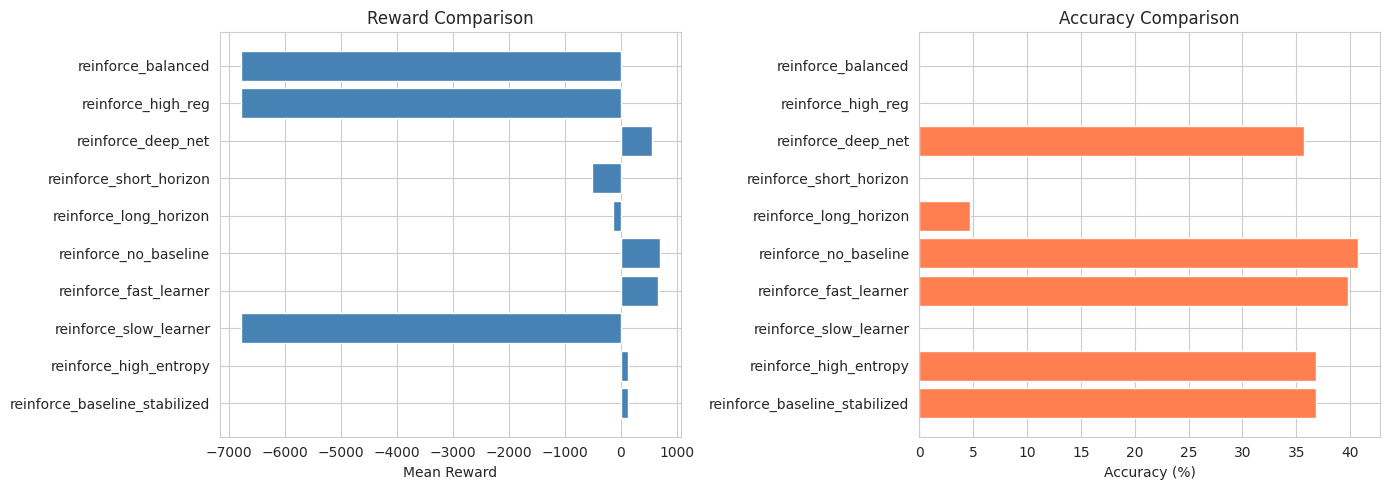


🏆 BEST CONFIGURATION: reinforce_no_baseline
   Mean Reward: 697.20
   Triage Accuracy: 40.7%

   Hyperparameters:
     learning_rate: 0.0001
     gamma: 0.99
     use_baseline: False
     entropy_coef: 0.01
     hidden_dims: [256, 256]


In [8]:
# Create results dataframe
sweep_df = pd.DataFrame(sweep_results)

# Save sweep results
sweep_csv_path = f"{PROJECT_DIR}/results/reinforce_sweep_results.csv"
save_results_to_csv(sweep_results, sweep_csv_path)

# Display sorted results
print("\n" + "="*60)
print("SWEEP RESULTS (sorted by mean reward)")
print("="*60)
print(sweep_df.sort_values('mean_reward', ascending=False)[
    ['config_id', 'mean_reward', 'triage_accuracy', 'training_time_sec']
].to_string(index=False))
print("="*60)

# Plot comparison
plot_config_comparison(
    sweep_df,
    save_path=f"{PROJECT_DIR}/plots/reinforce_sweep_comparison.png"
)

# Identify best config
best_config_id = sweep_df.loc[sweep_df['mean_reward'].idxmax(), 'config_id']
best_config = next(c for c in configs if c['id'] == best_config_id)

print(f"\n🏆 BEST CONFIGURATION: {best_config_id}")
print(f"   Mean Reward: {sweep_df.loc[sweep_df['mean_reward'].idxmax(), 'mean_reward']:.2f}")
print(f"   Triage Accuracy: {sweep_df.loc[sweep_df['mean_reward'].idxmax(), 'triage_accuracy']:.1f}%")
print(f"\n   Hyperparameters:")
for key in ['learning_rate', 'gamma', 'use_baseline', 'entropy_coef', 'hidden_dims']:
    print(f"     {key}: {best_config[key]}")
